## Task: Predict the outcome of a football match, based on historical match and player data.

You are provided with football matches dataset. This dataset includes historical match outcomes, player statistics, and other relevant factors. Your objective is to develop a multiclass classification model that accurately predicts the result of a football match: "home win", "away win", or "draw".

Your target is the column: "Score".

You are provided with the code to download and load the csv file.

Your work will be evaluated based on the completion of the following tasks:

Tasks:
> *  EDA & Preprocessing: You should check the following points and ADD COMMENTS about your findings:
>   
>    1- Imbalance.
>    
>    2- Missing values.
>    
>    3- Duplicates.
>    
>    4- Categorical values.
> * Baseline: Create a majority class baseline.
> * Build a ML model: Train and evaluate using K-Fold (K=5) without shuffling, and with F1 Score as the metric.
> * Plot the features importance of your model.
> * Performance: Achieve F1 Score ≥ 0.5
> * (Bonus): Use "VotingClassifier" from sklearn with voting="soft" to combine more than one model together then print the score (Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

Note: You are allowed to use any models or libraries you want.
    

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
import optuna
tqdm.pandas()

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

from lightgbm import LGBMClassifier
from xgboost import  XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
#pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams["figure.figsize"] = (12, 8)
pd.set_option('display.max_columns', None)

# Read the training and testing data


In [ ]:
train_df = pd.read_csv("/kaggle/input/football-data/data.csv")

Target Distribution:
Score
Home Win    0.398058
Draw        0.327670
Away win    0.274272
Name: proportion, dtype: float64


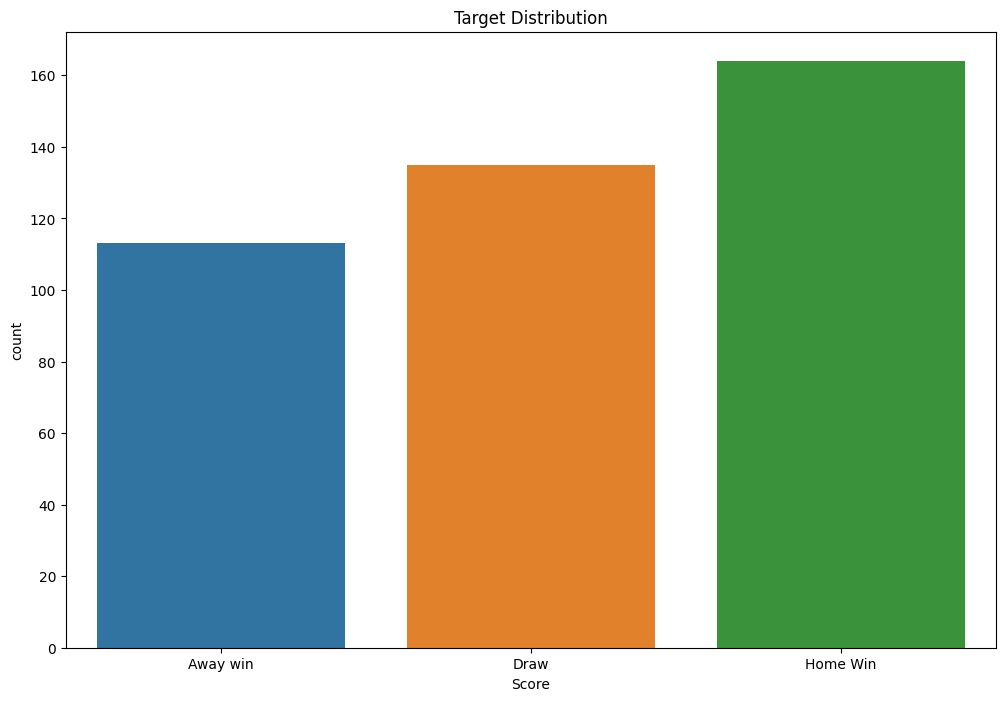

In [ ]:
# 1. Is the target imbalanced?
def check_target_imbalance(df, target_column):
    print("Target Distribution:")
    print(df[target_column].value_counts(normalize=True))
    sns.countplot(x=df[target_column])
    plt.title("Target Distribution")
    plt.show()

check_target_imbalance(train_df, "Score")

### Comment: Data is relatively balanced.

In [ ]:
# 2. Do we have missing values?
def check_missing_values(df):
    missing_values = df.isnull().sum()
    print("Missing Values per Column:")
    print(missing_values[missing_values > 0])
    if missing_values.any():
        print("\nHandle Missing Values as needed.")
    else:
        print("\nNo Missing Values Found.")

check_missing_values(train_df)

Missing Values per Column:
Series([], dtype: int64)

No Missing Values Found.


In [ ]:
# 4. Do we have duplicate samples?
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    print(f"Number of Duplicate Samples: {duplicates}")
    if duplicates > 0:
        print("Dropping Duplicates...")
        df.drop_duplicates(inplace=True)
        print("Duplicates Dropped.")
    else:
        print("No Duplicate Samples Found.")

check_duplicates(train_df)

Number of Duplicate Samples: 0
No Duplicate Samples Found.


In [ ]:
# 3. Do we have categorical columns?
def encode_categorical_columns(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    print("Categorical Columns:", list(categorical_cols))

label_encoders = encode_categorical_columns(train_df)

Categorical Columns: ['Home Team', 'Away Team', 'Score']


In [ ]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = train_df.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    print(f"Encoding column: {col}")
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
train_df

Encoding column: Home Team
Encoding column: Away Team
Encoding column: Score


,Season,Home Team,Away Team,Score,Month,Year,WeekOfYear,TotalShotsPerHomeTeam,TotalSoTPerHomeTeam,TotalPassesPerHomeTeam,TotalAccurPerHomeTeam,TotalInaccurPerHomeTeam,TotalShotsPerAwayTeam,TotalSoTPerAwayTeam,TotalPassesPerAwayTeam,TotalAccurPerAwayTeam,TotalInaccurPerAwayTeam,ShotsHomeAway_diff,SoTHomeAway_diff,TotalShotsPerMatch,TotalSoTPerMatch,TotalPassesPerMatch,TotalAccurPerMatch,TotalInaccurPerMatch,AccurPassesHome,AccurPassesAway,AccurPassesMatch,ShotsPerHalf1Home,ShotsPerHalf2Home,SoTPerHalf1Home,SoTPerHalf2Home,PassesPerHalf1Home,PassesPerHalf2Home,AccurPerHalf1Home,AccurPerHalf2Home,InaccurPerHalf1Home,InaccurPerHalf2Home,AccurPassesPerHalf1Home,AccurPassesPerHalf2Home,ShotsPerHalf1Away,ShotsPerHalf2Away,SoTPerHalf1Away,SoTPerHalf2Away,PassesPerHalf1Away,PassesPerHalf2Away,AccurPerHalf1Away,AccurPerHalf2Away,InaccurPerHalf1Away,InaccurPerHalf2Away,AccurPassesPerHalf1Away,AccurPassesPerHalf2Away,ShotsHalf1_diff,ShotsHalf2_diff,SoTHalf1_diff,SoTHalf2_diff
0,1,1,0,0,2,2017,46,8.0,2.0,340.0,265.0,75.0,5.0,1.0,508.0,433.0,75.0,3.0,1.0,13.0,3.0,848.0,698.0,150.0,0.7793,0.8525,0.8230,2.0,6.0,0.0,2.0,153.0,187.0,116.0,149.0,37.0,38.0,0.7583,0.7970,1.0,4.0,0.0,1.0,314.0,194.0,271.0,162.0,43.0,32.0,0.8633,0.8350,1.0,2.0,0.0,1.0
1,1,0,1,1,9,2016,258,5.0,1.0,443.0,354.0,89.0,10.0,0.0,462.0,386.0,76.0,-5.0,1.0,15.0,1.0,905.0,740.0,165.0,0.7993,0.8354,0.8180,2.0,3.0,0.0,1.0,245.0,198.0,205.0,149.0,40.0,49.0,0.8370,0.7524,2.0,8.0,0.0,0.0,205.0,257.0,174.0,212.0,31.0,45.0,0.8486,0.8247,0.0,-5.0,0.0,1.0
2,1,0,3,0,12,2016,347,3.0,0.0,669.0,554.0,115.0,6.0,2.0,388.0,279.0,109.0,-3.0,-2.0,9.0,2.0,1057.0,833.0,224.0,0.8280,0.7190,0.7880,2.0,1.0,0.0,0.0,266.0,403.0,216.0,338.0,50.0,65.0,0.8120,0.8390,2.0,4.0,1.0,1.0,245.0,143.0,185.0,94.0,60.0,49.0,0.7550,0.6570,0.0,-3.0,-1.0,-1.0
3,1,0,5,0,1,2017,25,5.0,2.0,384.0,281.0,103.0,11.0,3.0,446.0,353.0,93.0,-6.0,-1.0,16.0,5.0,830.0,634.0,196.0,0.7320,0.7915,0.7637,2.0,3.0,0.0,2.0,216.0,168.0,171.0,110.0,45.0,58.0,0.7915,0.6550,4.0,7.0,1.0,2.0,220.0,226.0,174.0,179.0,46.0,47.0,0.7910,0.7920,-2.0,-4.0,-1.0,0.0
4,1,0,6,2,8,2016,237,13.0,2.0,542.0,436.0,106.0,5.0,0.0,566.0,452.0,114.0,8.0,2.0,18.0,2.0,1108.0,888.0,220.0,0.8040,0.7990,0.8013,5.0,8.0,0.0,2.0,273.0,269.0,224.0,212.0,49.0,57.0,0.8203,0.7880,1.0,4.0,0.0,0.0,292.0,274.0,237.0,215.0,55.0,59.0,0.8115,0.7847,4.0,4.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,1,14,12,0,8,2016,241,4.0,0.0,556.0,447.0,109.0,10.0,3.0,434.0,347.0,87.0,-6.0,-3.0,14.0,3.0,990.0,794.0,196.0,0.8040,0.7993,0.8022,0.0,4.0,0.0,0.0,303.0,253.0,251.0,196.0,52.0,57.0,0.8286,0.7750,4.0,6.0,1.0,2.0,230.0,204.0,190.0,157.0,40.0,47.0,0.8260,0.7695,-4.0,-2.0,-1.0,-2.0
408,1,12,14,2,2,2017,50,15.0,5.0,503.0,413.0,90.0,9.0,1.0,410.0,338.0,72.0,6.0,4.0,24.0,6.0,913.0,751.0,162.0,0.8213,0.8240,0.8228,7.0,8.0,3.0,2.0,262.0,241.0,217.0,196.0,45.0,45.0,0.8280,0.8135,3.0,6.0,1.0,0.0,244.0,166.0,208.0,130.0,36.0,36.0,0.8525,0.7830,4.0,2.0,2.0,2.0
409,1,12,15,2,10,2016,297,14.0,4.0,437.0,365.0,72.0,12.0,2.0,346.0,263.0,83.0,2.0,2.0,26.0,6.0,783.0,628.0,155.0,0.8354,0.7603,0.8022,6.0,8.0,2.0,2.0,200.0,237.0,164.0,201.0,36.0,36.0,0.8200,0.8480,5.0,7.0,1.0,1.0,156.0,190.0,115.0,148.0,41.0,42.0,0.7373,0.7790,1.0,1.0,1.0,1.0
410,1,13,14,1,8,2017,228,14.0,5.0,561.0,475.0,86.0,6.0,4.0,403.0,335.0,68.0,8.0,1.0,20.0,9.0,964.0,810.0,154.0,0.8467,0.8310,0.8403,7.0,7.0,2.0,3.0,283.0,278.0,243.0,232.0,40.0,46.0,0.8590,0.8345,1.0,5.0,1.0,3.0,217.0,186.0,186.0,149.0,31.0,37.0,0.8570,0.8013,6.0,2.0,1.0,0.0


In [ ]:
# Modeling
X = train_df.drop("Score",axis=1)
y = train_df['Score']

In [ ]:
# Calculate the majority class baseline
majority_class = y.value_counts().idxmax()
baseline_pred = [majority_class] * len(y)

# Evaluate the baseline
baseline_f1 = f1_score(y, baseline_pred, average='weighted')
print(f"Baseline F1-Score (majority class): {baseline_f1:.4f}")


Baseline F1-Score (majority class): 0.2267


In [ ]:
# Define classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=100),
    "CatBoost Classifier": CatBoostClassifier(verbose=0)
}

models["Ensemble"] = VotingClassifier(estimators=[
        ('lr', models["CatBoost Classifier"]), ('rf', models["Logistic Regression"]), ('gnb', models["Random Forest Classifier"])], voting="soft")

for model_name, model in models.items():
    scores_accuracy = []
    scores_precision = []
    scores_recall = []
    scores_f1 = []

    # Stratified 5-Fold Cross-Validation
    skf = KFold(n_splits=5)
    for train_index, test_index in skf.split(X, y):
        # Split data into training and testing sets
        X_Train, X_Test = X.loc[train_index, :], X.loc[test_index, :]
        y_Train, y_Test = y.iloc[train_index], y.iloc[test_index]
        # Train the model
        model.fit(X_Train, y_Train)
        # Predict on the test set
        y_pred = model.predict(X_Test)

        # Calculate metrics
        scores_f1.append(f1_score(y_Test, y_pred, average='weighted'))

    # Print the results
    print(f"{model_name} F1-Score: {np.mean(scores_f1):.4f}")
    print("\n")


Logistic Regression F1-Score: 0.5146


Random Forest Classifier F1-Score: 0.4828


CatBoost Classifier F1-Score: 0.5088


Ensemble F1-Score: 0.5027




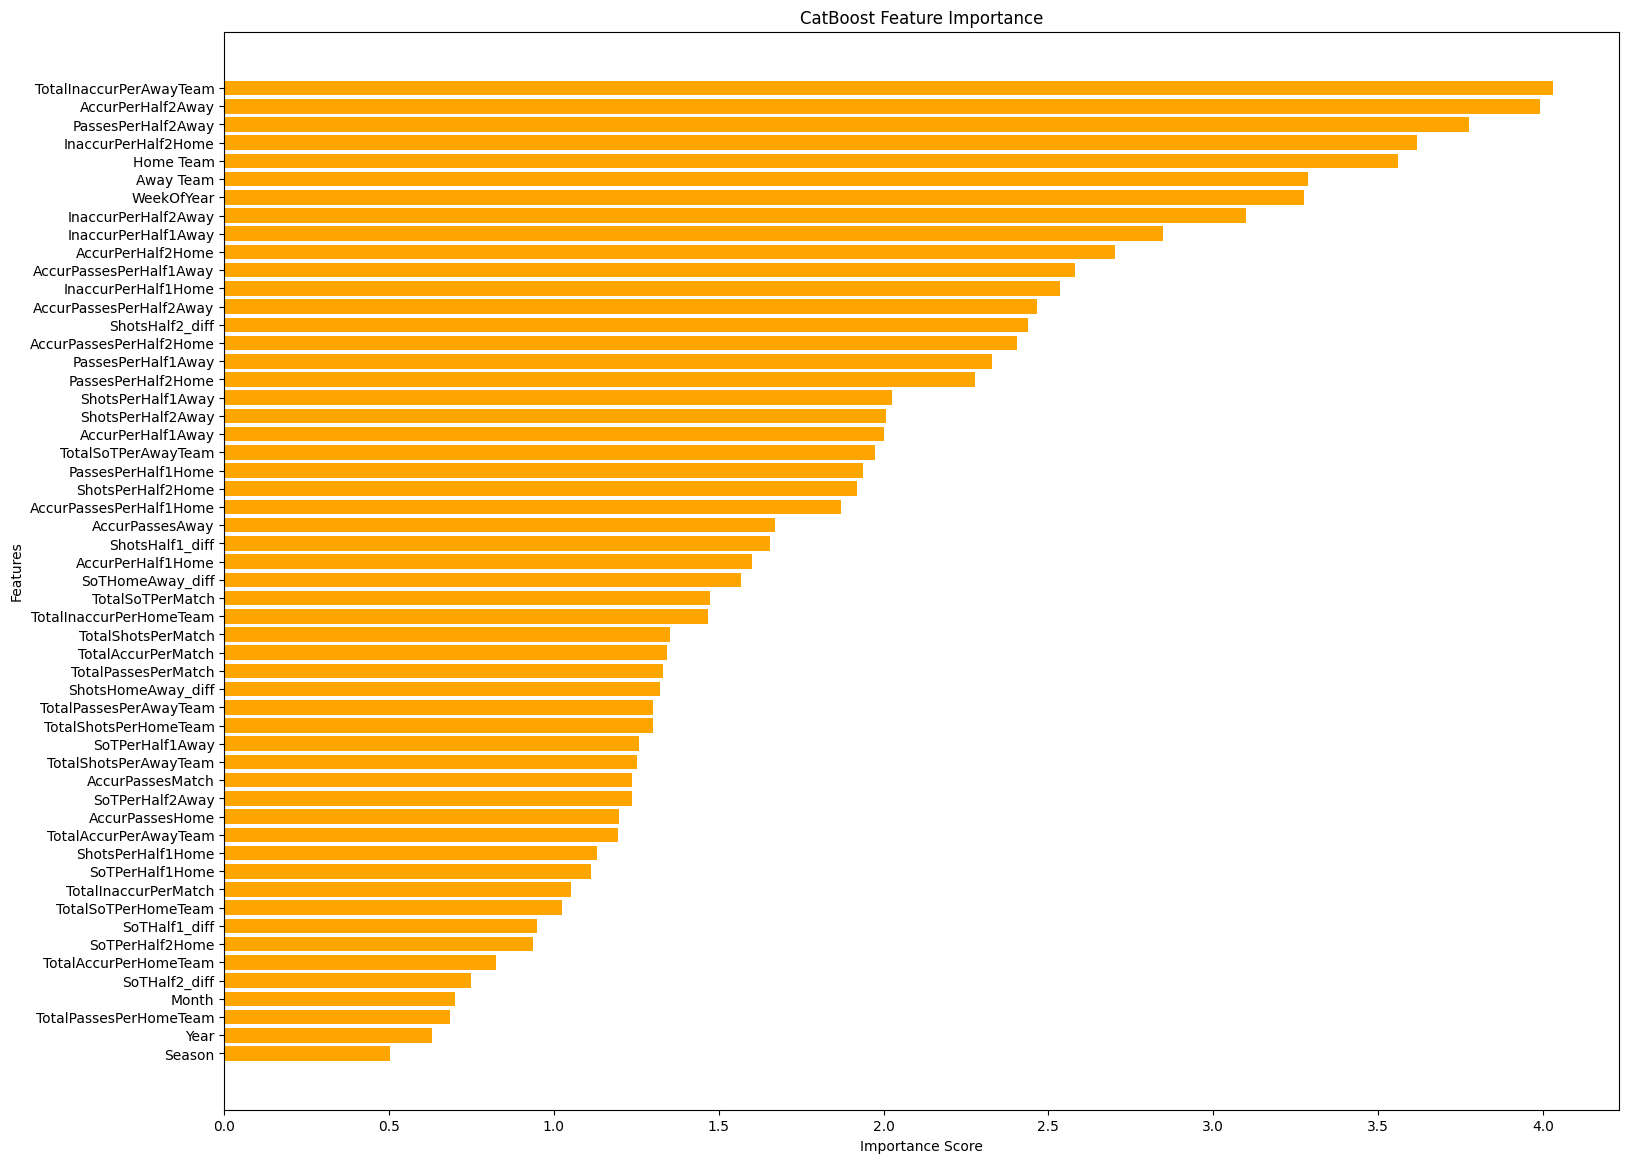

In [ ]:
# Retrieve CatBoost feature importances and sort them
catboost_model = models["CatBoost Classifier"]
catboost_importance = list(zip(X.columns, catboost_model.feature_importances_))
sorted_catboost_importance = sorted(catboost_importance, key=lambda x: x[1], reverse=True)

# Extract features and their importances
features, importances = zip(*sorted_catboost_importance)

# Plot feature importances
plt.figure(figsize=(18, 14))
plt.barh(features, importances, color='orange')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.show()
